# Etapa 3 – Python + SQL

Análise de dados utilizando SQLite e bibliotecas Python.

---

## Índice

- [1. Bibliotecas](#1-bibliotecas)  
- [2. Carregamento dos arquivos e criação do banco](#2-carregamento-dos-arquivos-e-criação-do-banco)  
- [3. Análises Estatísticas](#3-análises-estatísticas)  
  - [3.1 Total de Pedidos por Estado](#31-total-de-pedidos-por-estado)  
  - [3.2 Total de Vendas por Mês e Ano](#32-total-de-vendas-por-mês-e-ano)  
  - [3.3 Ticket Médio por Estado](#33-ticket-médio-por-estado)  
  - [3.4 Categorias mais Vendidas](#34-categorias-mais-vendidas)  
  - [3.5 Formas de Pagamento](#35-formas-de-pagamento)  
  - [3.6 Distribuição de Avaliações](#36-distribuição-de-avaliações)
  - [3.7 Distribuição de Pedidos por Vendedor](#36-distribuição-de-pedidos-por-vendedor)  
  - [3.8 Categorias mais Vendidas](#37-categorias-mais-vendidas)  
- [4. Visualizações](#4-visualizações)  
- [5. Conclusões](#5-conclusões)


## 1. Bibliotecas

In [2]:
#importação das bibliotecas que serão utilizadas
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## 2. Carregamento dos arquivos e criação do banco

In [6]:
#Abre conexão com o banco
sql = sqlite3.connect('etapa3.db')

#Mapeamento de nome de tabelas e seus respectivos arquivos
arquivos = {'avaliacoes_pedidos': 'avaliacoes_pedidos.csv',
    'categorias_produtos': 'categorias_produtos.csv',
    'clientes': 'clientes.csv',
    'geolocalizacao': 'geolocalizacao.csv',
    'itens_pedidos': 'itens_pedidos.csv',
    'pedidos': 'pedidos.csv',
    'pedidos_pagamentos': 'pedidos_pagamentos.csv',
    'produtos': 'produtos.csv',
    'vendedores': 'vendedores.csv'}

#Criando tabelas e salvando no banco
for tabela, arquivo in arquivos.items():
    print(f"Inserindo Tabela '{tabela}' ao banco.")
    dataf = pd.read_csv(f'/etapa3/{arquivo}')
    dataf.to_sql(tabela, sql, if_exists='replace', index=False)

Inserindo Tabela 'avaliacoes_pedidos' ao banco.
Inserindo Tabela 'categorias_produtos' ao banco.
Inserindo Tabela 'clientes' ao banco.
Inserindo Tabela 'geolocalizacao' ao banco.
Inserindo Tabela 'itens_pedidos' ao banco.
Inserindo Tabela 'pedidos' ao banco.
Inserindo Tabela 'pedidos_pagamentos' ao banco.
Inserindo Tabela 'produtos' ao banco.
Inserindo Tabela 'vendedores' ao banco.


## 3. Análises Estatísticas

### 3.1. Total de Pedidos por Estado

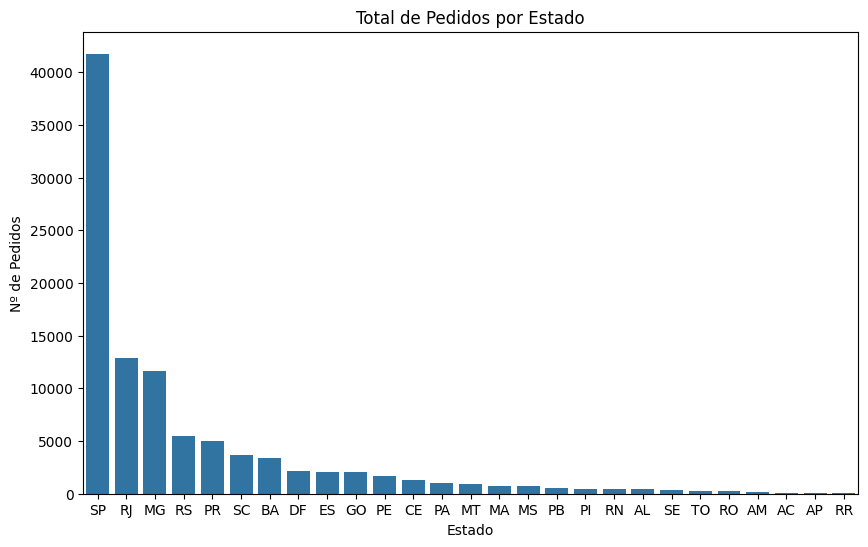

In [ ]:
# Select para buscar o total de pedidos, sem repetição e por estado.
# Para isso foi necessário fazer join com a tabela clientes porque pedido não possui estado
# Ordena do maior para o menor

query = '''SELECT c.customer_state, COUNT(DISTINCT p.order_id) AS total_pedidos
FROM pedidos p
JOIN clientes c ON p.customer_id = c.customer_id
GROUP BY c.customer_state
ORDER BY total_pedidos DESC
'''
df_pedidos_estado = pd.read_sql_query(query, sql)

# Definição do tamanho do gráfico
plt.figure(figsize=(10, 6))
# Gera gráfico com seaborn
sns.barplot(data=df_pedidos_estado, x='customer_state', y='total_pedidos')
plt.title('Total de Pedidos por Estado')
plt.xlabel('Estado')
plt.ylabel('Nº de Pedidos')
plt.show()

### 3.2. Total de Vendas por Mês e Ano

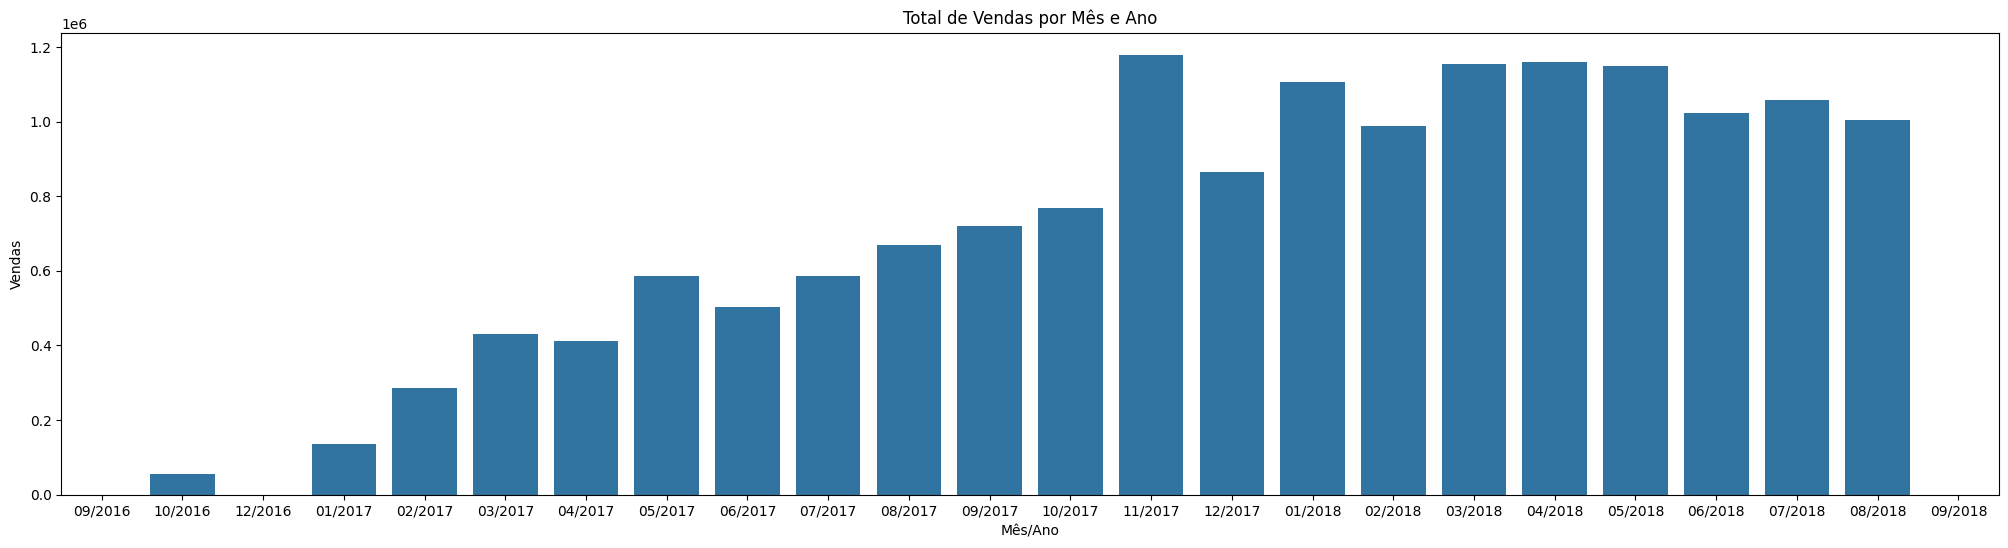

In [37]:
# Select para buscar o total de pedidos por mês e ano.
# Formatação de data utilzando STRFTIME
# Agrupa e ordena por mes_ano
# Utiliza uma segunda busca de data pra resolver o problema de ordenação

query = '''SELECT STRFTIME('%m/%Y', p.order_purchase_timestamp) AS mes_ano,
ROUND(SUM(i.price + i.freight_value), 2) AS total_vendas,
STRFTIME('%Y-%m', p.order_purchase_timestamp) AS ordenacao
FROM pedidos p
JOIN itens_pedidos i ON p.order_id = i.order_id
WHERE p.order_purchase_timestamp IS NOT NULL
GROUP BY mes_ano
ORDER BY ordenacao
'''
venda_mes = pd.read_sql_query(query, sql)

# Definição do tamanho do gráfico
plt.figure(figsize=(25, 6))
# Gera gráfico com seaborn
sns.barplot(data=venda_mes, x='mes_ano', y='total_vendas')
plt.title('Total de Vendas por Mês e Ano')
plt.xlabel('Mês/Ano')
plt.ylabel('Vendas')
plt.show()

### 3.3 Ticket Médio por Estado

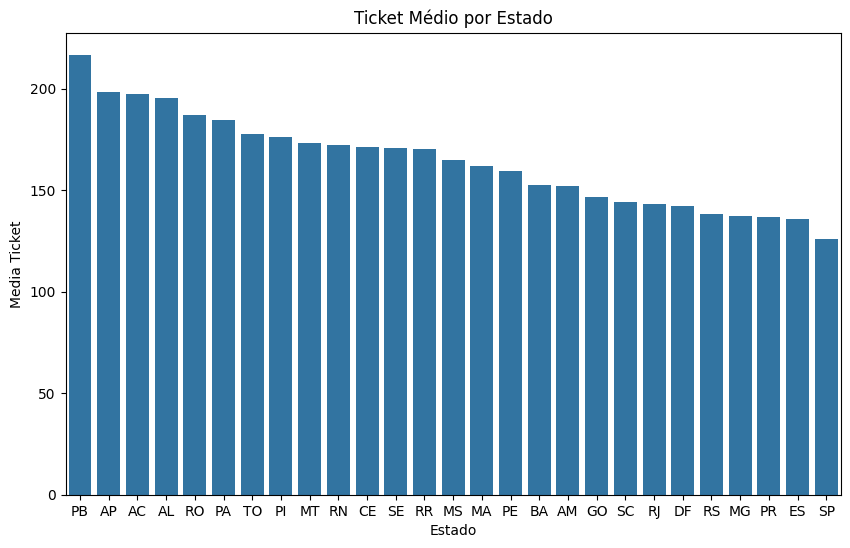

In [ ]:
# Select para buscar o valor de ticket médio por estado.
# Formatação de data utilzando STRFTIME
# Faz join com cliente para acessar o atributo estado
# Faz join com itens_pedido para acessar o price
# Agrupa por estado
# Ordena por valor

query = '''SELECT c.customer_state,
ROUND(SUM(i.price) / COUNT(DISTINCT p.order_id), 2) AS ticket_medio
FROM pedidos p
JOIN clientes c ON p.customer_id = c.customer_id
JOIN itens_pedidos i ON p.order_id = i.order_id
GROUP BY c.customer_state
ORDER BY ticket_medio DESC
'''

df_venda_mes = pd.read_sql_query(query, sql)

# Definição do tamanho do gráfico
plt.figure(figsize=(10, 6))
# Gera gráfico com seaborn
sns.barplot(data=df_venda_mes, x='customer_state', y='ticket_medio')
plt.title('Ticket Médio por Estado')
plt.xlabel('Estado')
plt.ylabel('Media Ticket')
plt.show()

### 3.4 Categorias mais Vendidos

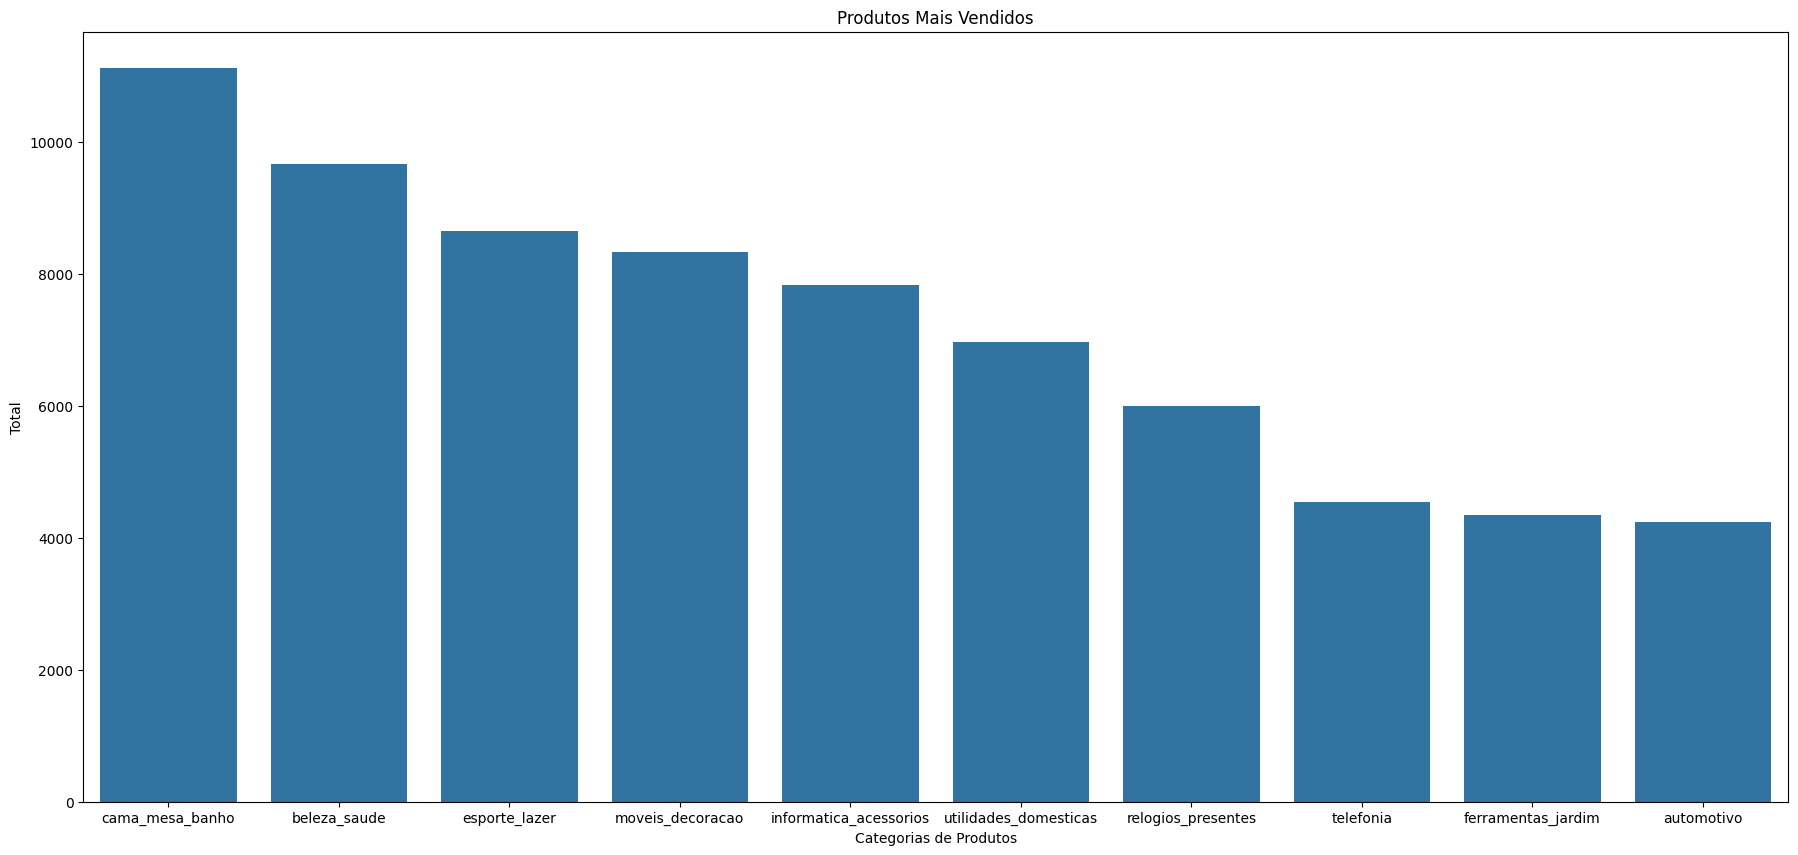

In [18]:
# Select para buscar o top 10 de produtos mais vendidos.
# Formatação de data utilzando STRFTIME
# Faz join com produtos para acessar as categorias
# Agrupa por categoria
# Ordena pelo total de itens

query = '''SELECT
pr.product_category_name,
COUNT(*) AS total_itens
FROM itens_pedidos i
JOIN produtos pr ON i.product_id = pr.product_id
GROUP BY pr.product_category_name
ORDER BY total_itens DESC
LIMIT 10
'''
df_venda_mes = pd.read_sql_query(query, sql)

# Definição do tamanho do gráfico
plt.figure(figsize=(22, 10))
# Gera gráfico com seaborn
sns.barplot(data=df_venda_mes, x='product_category_name', y='total_itens')
plt.title('Produtos Mais Vendidos')
plt.xlabel('Categorias de Produtos')
plt.ylabel('Total')
plt.show()

### 3.5 Formas de Pagamento

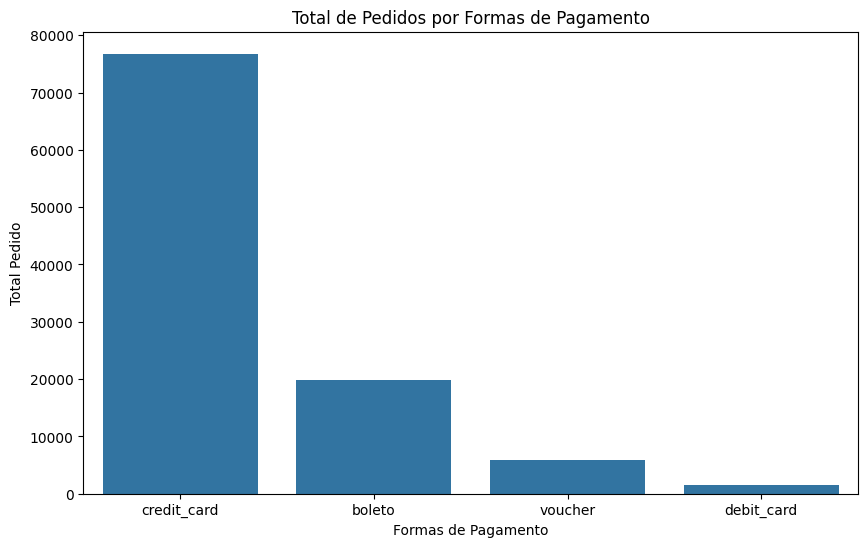

In [29]:
# Select para buscar os meios de pagamento mais utilizados.
# remove os meios de pagamento 'not_defined', pois foi verificado na planilha que só existem 3 ocorrências e para valores zerados
# Agrupa por meio de pagamento
# Ordena pelo total de pedidos

query = '''SELECT
payment_type AS tipo_pagamento,
COUNT(*) AS total_pedidos
FROM pedidos_pagamentos
WHERE payment_type IS NOT 'not_defined'
GROUP BY payment_type
ORDER BY total_pedidos DESC
'''
pagamento = pd.read_sql_query(query, sql)

# Definição do tamanho do gráfico
plt.figure(figsize=(10, 6))
# gera gráfico com seaborn
sns.barplot(data=pagamento, x='tipo_pagamento', y='total_pedidos')
plt.title('Total de Pedidos por Formas de Pagamento')
plt.xlabel('Formas de Pagamento')
plt.ylabel('Total Pedido')
plt.show()

### 3.6 Distribuição de Avaliações

In [26]:
# Select para buscar a distribuição de avaliações.
# Agrupa e ordena por avaliações

query = '''SELECT
review_score AS avaliacao,
COUNT(*) AS total_avaliacoes
FROM avaliacoes_pedidos
GROUP BY review_score
ORDER BY review_score DESC
'''
avaliacoes = pd.read_sql_query(query, sql)

# Gera gráfico de pizza com plotly.express
fig = px.pie(avaliacoes, names='avaliacao', values='total_avaliacoes',
             title='Distribuição de Avaliações')
fig.show()

### 3.7 Distribuição de pedidos por vendedor

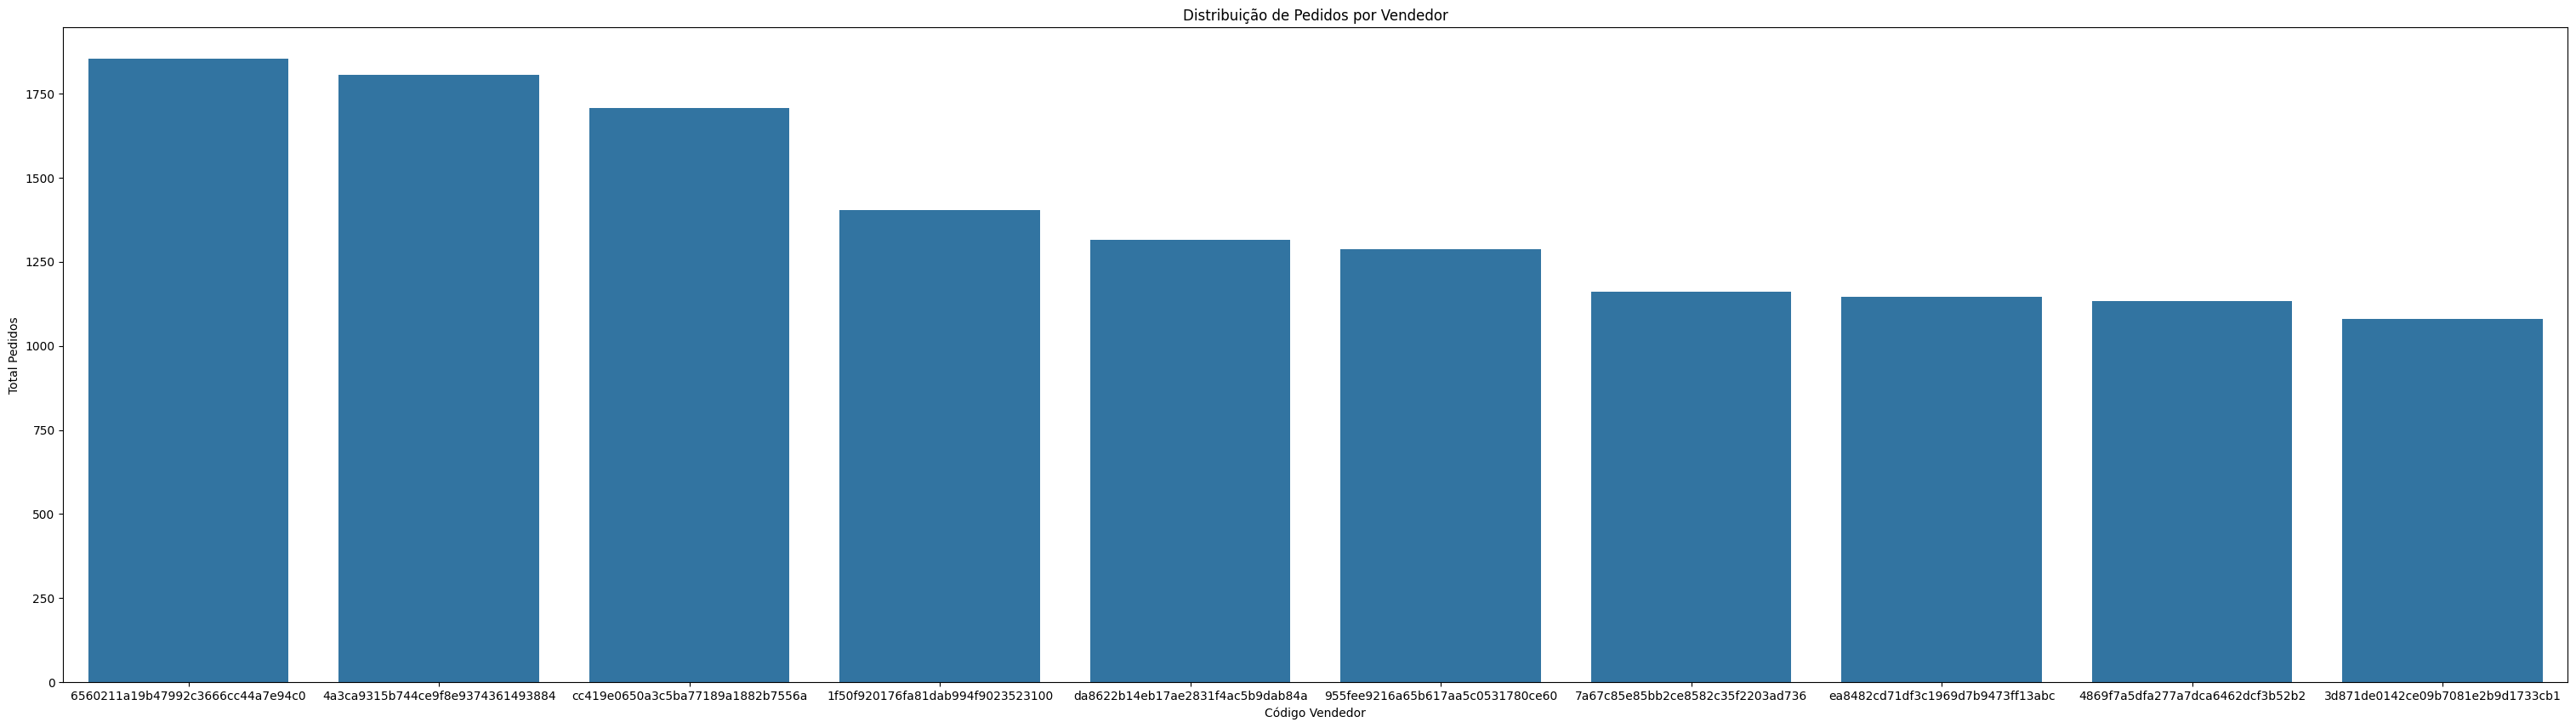

In [ ]:
# Select para consultar a distribuição de pedidos por vendedor.
# Agrupa por vendedores
# Ordena pelo total de pedidos

query = '''SELECT
v.seller_id,
COUNT(DISTINCT p.order_id) AS total_pedidos
FROM pedidos p
JOIN itens_pedidos i ON p.order_id = i.order_id
JOIN vendedores v ON i.seller_id = v.seller_id
GROUP BY v.seller_id
ORDER BY total_pedidos DESC
LIMIT 10
'''
df_venda_mes = pd.read_sql_query(query, sql)

# Definição do tamanho do gráfico
plt.figure(figsize=(38, 10))
# Gera gráfico com seaborn
sns.barplot(data=df_venda_mes, x='seller_id', y='total_pedidos')
plt.title('Distribuição de Pedidos por Vendedor')
plt.xlabel('Código Vendedor')
plt.ylabel('Total Pedidos')
plt.show()

### 3.8 Categorias mais Vendidas

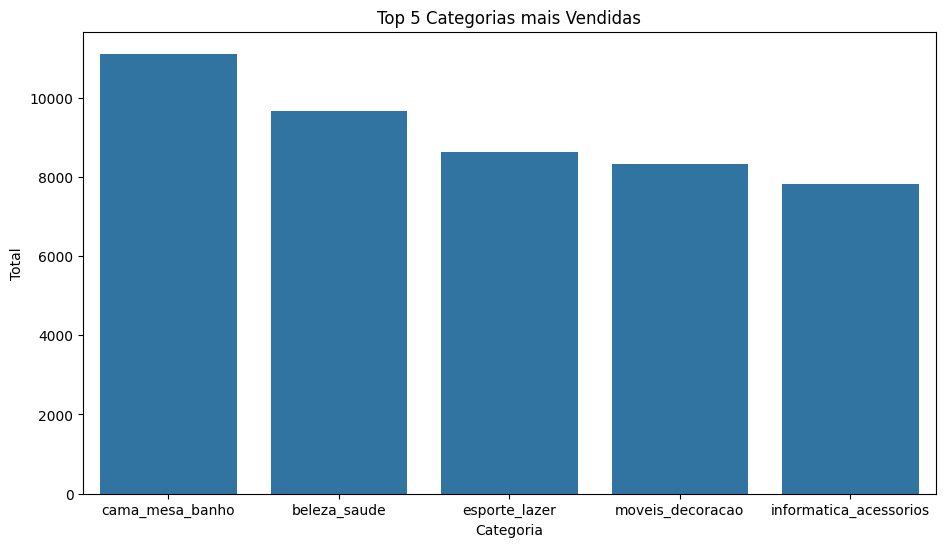

In [33]:
# Select para buscar o top 5 de ctegorias mais vendidas.
# faz join com produtos para acessar as categorias
# Agrupa por categorias
# Ordena pelo total de itens vendidos

query = '''SELECT
pr.product_category_name AS categoria,
COUNT(*) AS total_vendido
FROM itens_pedidos i
JOIN produtos pr ON i.product_id = pr.product_id
GROUP BY pr.product_category_name
ORDER BY total_vendido DESC
LIMIT 5
'''
categorias_mais_vendidas = pd.read_sql_query(query, sql)

# Definição do tamanho do gráfico
plt.figure(figsize=(11, 6))
# Gera gráfico com seaborn
sns.barplot(data=venda_mes, x='categoria', y='total_vendido')
plt.title('Top 5 Categorias mais Vendidas')
plt.xlabel('Categoria')
plt.ylabel('Total')
plt.show()

## 4. Visualizações

In [38]:
# Plotagem de gráficos utilizando plotly.express
# Mesma lógica dos gráficos anteriores, porem apresentados em forma de painel e utilizando plotly.express por ser interativo

#Vendas por mês/ano
fig = px.line(venda_mes, x='mes_ano', y='total_vendas', title='Vendas por Mês')
fig.update_layout(xaxis_title='Mês', yaxis_title='Total de Vendas')
fig.show()

#Avaliações
fig = px.bar(avaliacoes, x='avaliacao', y='total_avaliacoes',
             title='Distribuição de Avaliações', color='total_avaliacoes', color_continuous_scale='viridis')
fig.show()

#Pagamento
fig = px.pie(pagamento, names='tipo_pagamento', values='total_pedidos',
             title='Distribuição de Formas de Pagamento')
fig.show()

#Top 5 categorias mais vendidas
fig = px.pie(categorias_mais_vendidas, names='categoria', values='total_vendido',
             title='TOP 5 categorias mais vendidas')
fig.show()


## 5. Conclusões

Como solicitado para essa etapa do desafio, utilizei Python (pandas, seaborn matplotlib e plotly) e SQL, que nesse caso utilizei SQLite. Com isso, pude fazer uma análise exploratória e obter as seguintes descobertas:

- São Paulo é o estado com maior índice de pedidos, seguido por RJ e MG. Ou seja, isso demonstra que a região sudeste domina a quantidade de vendas.
- O índice de vendas cresceu consideravelmente de 2016 a 2018.
- O estado da Paraíba é o que possui o maior valor de ticket médio. E que apesar de São Paulo possuir o maior volume de pedidos, ele possui um valor baixo de ticket médio.
- As categorias mais vendidas foram cama_mesa_banho, beleza_saúde, esporte_lazer.
- A forma de pagamento mais utilizada foi cartão de crédito, disparado em relação as outras formas de pagamento.
- Mais da metade das avaliações foram com a nota máxima, mantendo uma média de avaliação em 4,09, o que é muito bom.
- A quantidade de vendas por vendedor está bem distribuída.


